In [0]:
# --------------------------------
# Author : P. Mondal
# Date : March 7, 2020
# MCMC Outliers Probability
# --------------------------------

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
from scipy.optimize import curve_fit
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pip install emcee
!pip install corner

     |████████████████████████████████| 51kB 2.3MB/s 
  Created wheel for corner: filename=corner-2.0.1-cp36-none-any.whl size=11642 sha256=01c0c393d772c39a048e669d3e4666a98bf7615edb8e26431e38065cd0660ed8
  Stored in directory: /root/.cache/pip/wheels/70/d8/e5/e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner


In [0]:
import emcee
import corner
import scipy.optimize as op
from corner import hist2d

In [0]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def line(x, slope, intercept):
    """ creates a line 
    x: exogenous variable
    slope: slope line parameter
    intercept: intercept line parameter
    """
    return x * slope + intercept


Run the cells of code below until you reach the assignment cell. This will read in data and run simpler models that you can look at to help yourself creating the one in the assignment

# read in data

In [5]:
data = pd.read_csv("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/HW4/table1.dat",
                   sep=" ")
data.head()

,x,y,sy,sx,rxy
0,201,592,61,9,-0.84
1,244,401,25,4,0.31
2,47,583,38,11,0.64
3,287,402,15,7,-0.27
4,203,495,21,5,-0.33


In [0]:
nall = len(data)
n = nall - 5

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Plot of initial data with four predefined outliers')

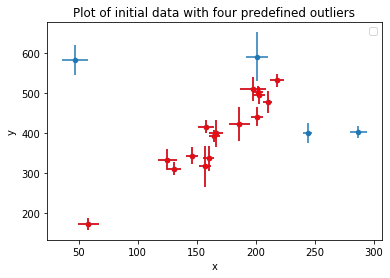

In [0]:
ax = data.plot(x='x', y="y", yerr="sy", xerr="sx", kind="scatter");
data[4:].plot(x='x', y="y", yerr="sy", xerr="sx", kind="scatter", ax=ax, color='r');
pl.xlabel("x")
pl.ylabel("y")
pl.legend()
pl.rcParams["figure.figsize"] = (20,20)
pl.title('Plot of initial data with four predefined outliers')

Fig 1: All data from https://arxiv.org/pdf/1008.4686.pdf: data in red is the code dataset, data in blue are presumed outliers

# get the initial guess by somple polynomial fitting to the restricted dataset

In [0]:
rdata = data[4:]    # Reduced data
pars = np.polyfit(rdata.x, rdata.y, 1)

## MCMC

Text(0.5, 1.0, 'Polynomial fit on the provided dataset')

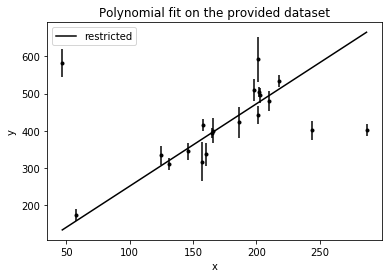

In [8]:
xx = np.arange(data.x.min(), data.x.max(), 0.1)
pl.errorbar(data.x, data.y, data.sy, fmt='.',  color='k')
pl.plot(xx, line(xx, pars[0], pars[1]), 'k-', label="restricted")
pl.xlabel("x")
pl.ylabel("y")
pl.legend();

pl.rcParams["figure.figsize"] = (3,2)
pl.title('Polynomial fit on the provided dataset')

Fig 2: the polynomial best fit obtained with numpy.polyfit() overplotted to the dataset in Figure 1.

In [0]:
#define a log likelihood that includes 
# - parameters slope and intercept (m, b), 
# - the probability that the point is an outlier Pb 
# - and a distribution of the outliers, parameters (Yb, Vb), the mean and variance of the distribution of outliers


# This code doesn't involve any outlier distribution
def lnlike(theta, x, y, yerr):
    '''log likelihood
    theta: 5 parameters vector, see prior for details,
    x: exogenous vextor
    y: endoogenous vector
    yerr: uncertainties vector
    '''
    
    m, b = theta
    #line fit model
    model = m * x + b
    #variance of data
    sig2 = yerr**2
    
    #normalization: this is importnat because we have 2 linearly combined pieces of model
    den = 2 * np.pi * sig2
    
    #this is the probability that the point comes from the line
    a = (1) / np.sqrt(den) *\
        exp(-(y-model)**2 /  2.0 / sig2)   
    return  np.sum(np.log(a))

In [0]:
def lnprior(theta):
    '''
    logprior on the parameters theta
    theta: 5 parameter vector: slpoe, intercept, 
                                Yb mean of the process that creates the outliers,
                                Pb probability that a point is an outlier,
                                V the variance of the process that generates outliers
    '''
    m, b = theta
    if -200 < b < 500 and 0 < m < 10.0 :
        #Pb is a probability so it is bound to 0-1
        return 0.0
    
    return -np.inf

def lnprob(theta, x, y, yerr):
    ''' log likelihood * log prior: the posterior
    '''
    lp = lnprior(theta)
    
    if not np.isfinite(lp) :
        return -np.inf
    lnl = lnlike(theta, x, y, yerr)
    if  np.isnan(lnl):
        return -np.inf
    return lp + lnl 

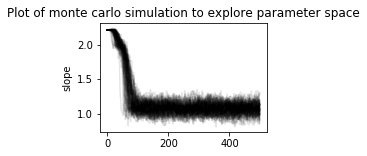

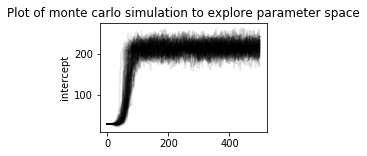

In [0]:
ndim, nwalkers = 2, 100 # number of variables optimized over, number of walkers per variable
init = np.hstack([pars[0], pars[1]]) # initialize the variable at a single point with some noise
pos = [init + 
       init * 1e-4 * np.random.randn(ndim) for i in range(nwalkers)] #  
sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                lnprob, 
                                args=(data.x, data.y,
                                     data.sy))
sampler.run_mcmc(pos, 500);
labels = ["slope", "intercept","Yb mean of the process that creates the outliers",
               "Pb probability that a point is an outlier",
                 "V" ]

for i in range(ndim):
    pl.figure()
    pl.title('Plot of monte carlo simulation to explore parameter space')        

    for j in range(100): 
        pl.plot(sampler.chain[j,:,i], 'k', alpha=0.1)
    pl.ylabel(labels[i])
        
pl.title('Plot of monte carlo simulation to explore parameter space')        
        
burnout = 150
samples = sampler.chain[:, burnout:, :].reshape((-1, ndim))

Fig 3: The walkers chains obtained from the ```ecmee``` implementation of the affine invariant algorithm https://emcee.readthedocs.io/en/stable/
The top panel shows variation in slope and bottom panel shows variation in intercept for each monte carlo step.

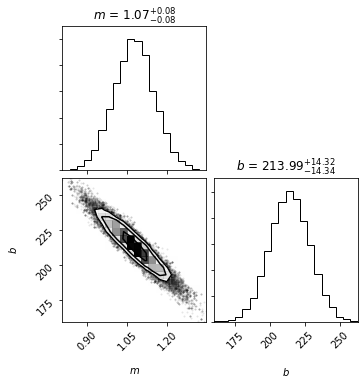

In [0]:
fig = corner.corner(samples, 
                        labels=["$m$", "$b$", "Y", r"$P_b$", "V"], show_titles = True,
                        truths=init, title=('Exploring parameter space (m, b) using Monte Carlo'))
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples[:,:2], [16, 50, 84],
                                                axis=0)))
# corner.corner??
fig.title=('Exploring parameter space (m, b) using Monte Carlo')

Fig 4: The top panel shows distribution of slope "m", bottom left panel shows plot of intercept vs slope and bottom right panel shows distribution of intercept.




Text(0.5, 1.0, 'Different fitting models over the dataset')

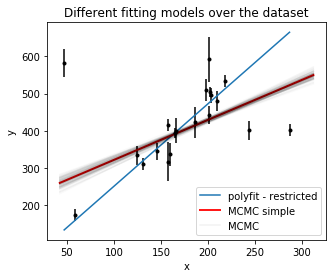

In [0]:
xl = np.arange(data.x.min() * 0.9, data.x.max() * 1.1, 10)
pl.errorbar(data.x, data.y, yerr=data.sy, fmt=".k")
pl.plot(xx, line(xx, pars[0], pars[1]), '-', label="polyfit - restricted")
pl.plot(xl, line(xl, m_mcmc[0], b_mcmc[0]), color="r", lw=2, 
        alpha=0.9, label="MCMC simple")
for m, b in samples[np.random.randint(len(samples), size=100)][:,:2]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.02)
pl.plot(xl, m*xl+b, color="k", alpha=0.05, label="MCMC")
pl.legend();
pl.xlabel("x")
pl.ylabel("y")
pl.legend();

pl.rcParams["figure.figsize"] = (5,6)
pl.title('Different fitting models over the dataset')

Fig 5: Same as Figure 2 with the results of the MCMC best fit to the sample likelihood equation derived from the assumption of a line generative process with Gaussian uncertainties. In red is the median value of the parameters slope and intercept optained with a 100 walkers over a 500 steps chain (removing a 150 points burn-in region) and in gray are random samples from the parameter distributions. 

The line fit diverges significantly from the original polynomial fit due to the inclusion of outlier points in the dataset. 

In [0]:
#define a log likelihood that includes 
# - parameters slope and intercept (m, b), 
# - the probability that the point is an outlier Pb 
# - and a distribution fo the outliers, parameters (Yb, Vb), the mean and variance of the distribution of outliers

def lnlike(theta, x, y, yerr):
    '''log likelihood
    theta: 5 parameters vector, see prior for details,
    x: exogenous vextor
    y: endoogenous vector
    yerr: uncertainties vector
    '''
    
    m, b, Yb, Pb, V = theta
    #line fit model
    model = m * x + b
    #variance of data
    sig2 = yerr**2
    
    #normalization: this is importnat because we have 2 linearly combined pieces of model
    den = 2 * np.pi * sig2
    
    #this is the probability that the point comes from the line
    linelik = (1 - Pb) / np.sqrt(den) *\
        exp(-(y-model)**2 /  2.0 / sig2)  
    #this is the probability that it does not
    gausslik = Pb / np.sqrt(den + 2*np.pi*V) *\
        exp (-(y - Yb)**2 / 2 / (V + sig2))
    return  np.sum(np.log(linelik + gausslik))

In [0]:
def lnprior(theta):
    '''
    logprior on the parameters theta
    theta: 5 parameter vector: slpoe, intercept, 
                                Yb mean of the process that creates the outliers,
                                Pb probability that a point is an outlier,
                                V the variance of the process that generates outliers
    '''
    m, b, Yb, Pb, V = theta
    if -200 < b < 500 and 0 < m < 10.0 :
        #Pb is a probability so it is bound to 0-1
        if Pb < 0 or Pb > 1:
            return -np.inf
        # set some constraints on the mean of the process that creates the outliers
        if  Yb > ymean + 150 or Yb < ymean - 150:
            return -np.inf

        if V < 0:
            return -np.inf
        #print("3")
        return 0.0
    
    return -np.inf

def lnprob(theta, x, y, yerr):
    ''' log likelihood * log prior: the posterior
    '''
    lp = lnprior(theta)
    
    if not np.isfinite(lp) :
        return -np.inf
    lnl = lnlike(theta, x, y, yerr)
    if  np.isnan(lnl):
        return -np.inf
    return lp + lnl 

In [0]:
ymean = data.y.mean()
#initialize from the restricted problem LA solution 


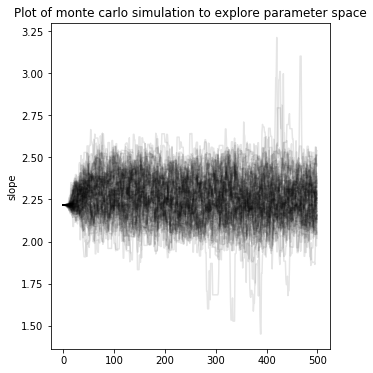

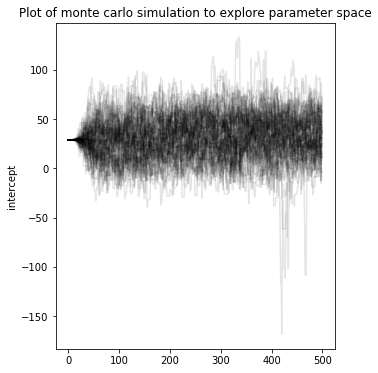

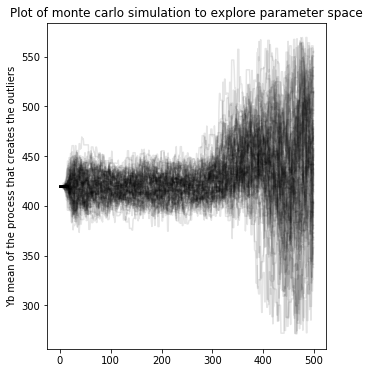

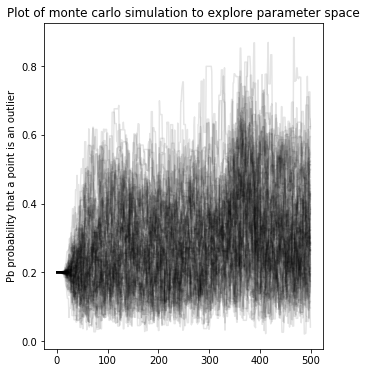

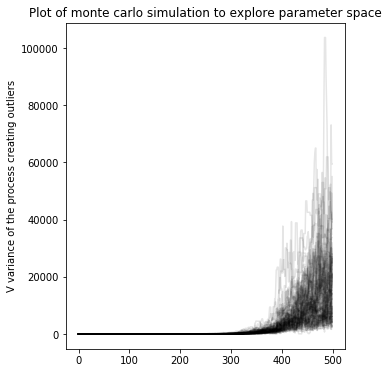

In [0]:
ndim, nwalkers = 5, 100 # number of variables optimized over, number of walkers per variable
init = np.hstack([pars[0], pars[1], ymean, 
                  0.2, 0.1]) # initialize the variable at a single point with some noise
pos = [init + 
       init * 1e-4 * np.random.randn(ndim) for i in range(nwalkers)] #  
sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                lnprob, 
                                args=(data.x, data.y,
                                     data.sy))
sampler.run_mcmc(pos, 500);
labels = ["slope", "intercept","Yb mean of the process that creates the outliers",
               "Pb probability that a point is an outlier",
                 "V variance of the process creating outliers" ]
for i in range(ndim):
    pl.figure()
    pl.title('Plot of monte carlo simulation to explore parameter space')        

    for j in range(100): 
        pl.plot(sampler.chain[j,:,i], 'k', alpha=0.1)
    pl.ylabel(labels[i])
        
pl.title('Plot of monte carlo simulation to explore parameter space')        
        
burnout = 150
samples = sampler.chain[:, burnout:, :].reshape((-1, ndim))

Fig 6: same as figure 3 for the parameters of a model tha includes the probability of a Gaussian generative porcess contaminating the dataset generated by a line-generating process (with added Gaussian noise). The added parameters, added to slope and intercept, are the mean and variance of the Gaussian generative process, and the probability that a point is generated by the extraneous provess (not the line) this model is obtained by marginalizing over all datapoints in the set a complete model that includes the individual probability of being generated bu the extraneous process for each datapoint. 

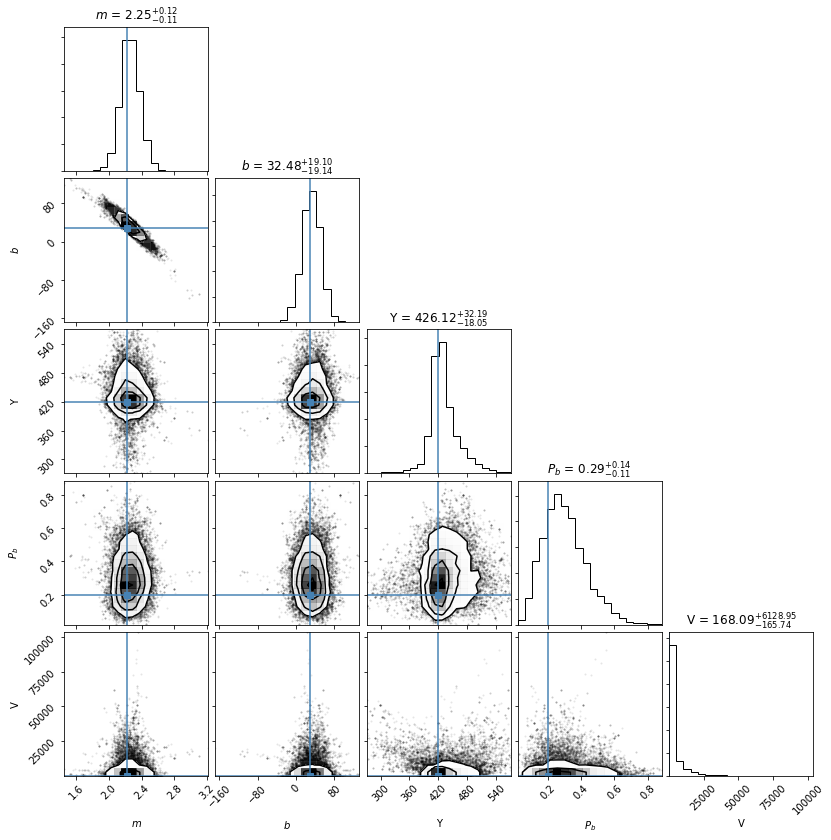

In [0]:
fig = corner.corner(samples, 
                        labels=["$m$", "$b$", "Y", r"$P_b$", "V"],show_titles = True,
                        truths=init)
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples[:,:2], [16, 50, 84],
                                                axis=0)))

Fig 7 : The above figure shows exploration of parameter space with monte carlo steps performed using $emcee$. Note the outlier parameters $P_b$, $Y$, $V$ are added to this model and are explored using $emcee$ here along with original line fitted model parameters m,b. 

Which parameters del are covariant? Do the parameters span the likelihood effectively? Any suspicious distribution shapes? ????

Text(0.5, 1.0, 'Different fitting models over the dataset')

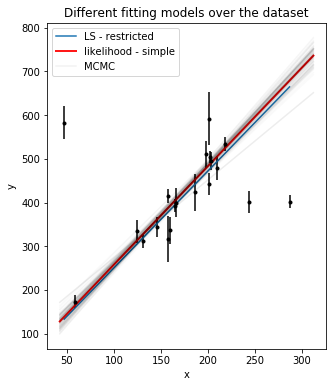

In [0]:
xl = np.arange(data.x.min() * 0.9, data.x.max() * 1.1, 10)
pl.errorbar(data.x, data.y, yerr=data.sy, fmt=".k")
pl.plot(xx, line(xx, pars[0], pars[1]), '-', label="LS - restricted")
pl.plot(xl, line(xl, m_mcmc[0], b_mcmc[0]), color="r", lw=2, alpha=0.9, label="likelihood - simple")
for m, b in samples[np.random.randint(len(samples), size=100)][:,:2]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.02)
pl.plot(xl, m*xl+b, color="k", alpha=0.05, label="MCMC")
pl.legend()

pl.xlabel("x")
pl.ylabel("y")
pl.rcParams["figure.figsize"] = (8,6)
pl.title('Different fitting models over the dataset')

Fig 8: The above figure shows the fitted model to original data using MCMC and shows comparison between three different models namely, $LS-restricted$, $likelihood -simple$ and $MCMC$. We have assumed that first four points are outlier and we do see that this approach gives better fitted model compared to Fig 5. 



# Homework:
##  Fit all Ps

Follow equation 13 in Paragraph 3 of https://arxiv.org/pdf/1008.4686.pdf and code it in the ```emcee``` framework. Obtain the probability that a point comes from the line-generating process, or a separate "Gaussian generative" process. 

Print the mean and standard deviations of the Gaussian generative process and their uncertainties. 

Plot all the walker chains (same as Fig 3 and 6 for this model)

Plot the marginalized parameter distributions (same as Fig 4 & 7 for this model)

Plot the data points, the best fit line and the lines generated by the MCMC ensambles (as I did in the previous figure) and print a label next to each point that shows the point index (the index of the row corresponding to that point in the source dataframe) and the probability that it is from the Gaussian generative process. Write in red the label if the probability of being an outlier is > 50%


In [10]:
x = data.x
y = data.y
print(x.shape)

(20,)


While implementing eq. 13, the value of q_i should be binary integer i.e. 0 or 
1 for all N number of points. For a given data (say i^th data point), how do I know whether it is 0 or 1 ? Do I assign it randomly ? 

In [0]:
''' Ans : Ah, the easy way to implement it (prob not the only one but one that 
does not make the math go crazy) is to set it up with a continuous probability 
for each q_i and then collapse the q_i s at the end to either 0 or 1 based on 
some threshold. The plot that I am askinng you to produce in fact shows a 
continuous p_i for each object (instead of a discrete q_i) thus your prior 
should be uninformative between 0 and 1 (since probabilities >1 or <0 dont make 
sense)
(uninformative is a loaded term to say flat, which is never uninformative.... 
think about changing coordinates for example... what was flat is no longer flat)
'''

' Ans : Ah, the easy way to implement it (prob not the only one but one that \ndoes not make the math go crazy) is to set it up with a continuous probability \nfor each q_i and then collapse the q_i s at the end to either 0 or 1 based on \nsome threshold. The plot that I am askinng you to produce in fact shows a \ncontinuous p_i for each object (instead of a discrete q_i) thus your prior \nshould be uninformative between 0 and 1 (since probabilities >1 or <0 dont make \nsense)\n(uninformative is a loaded term to say flat, which is never uninformative.... \nthink about changing coordinates for example... what was flat is no longer flat)\n'

# Question starts here :  

In [11]:

def get_qi(N, a, b, tol):
    ''' Returns : a numpy array of size N filled with binary integers drawn from 
                uniform probability distribution
      input  : N, a, b, tol

      parameters : 
        N    : integer
        a    : float, lower limit of generated array
        b    : float, upper limit of generated array
        tol  : float, tolerance to decide on binary integer value

      output : 
        qi   : numpy array of binary integers


      Author : P. Mondal
      Date   : March 11, 2020
    '''

    # Creates an array with elements drawn from uniform distribution
    s = np.random.uniform(0,1,N)
    qi = np.zeros(N)
    for ii in range(N):
      if s[ii] < tol:
        qi[ii] = 1
      else:
        qi[ii] = 0

    return qi

xx = get_qi(len(data.sy), 0, 1, 0.5)
#print(get_qi(10,10))
#xx.shape
#xx[:5]

# Checked that get_qi returns value between 0 to 1 i.e. probability
#print(np.all(xx<0))
#print(np.all(xx>1))
#print(np.all(xx<1))
print(xx)
# [0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]

[0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1.]


In [40]:
def lnlikeP(theta, x, y, yerr):
    '''log likelihood
    theta: 4 parameters vector, see prior for details,
    x: exogenous vextor
    y: endoogenous vector
    yerr: uncertainties vector
    P: probability that a point is an outlier, a x-long vector
    '''
# ----------------------------------------
    m, b, Yb, V = theta[0:4]
    #line fit model
    model = m * x + b
    #variance of data
    sig2 = yerr**2

    # normalization: this is importnat because we have 2 linearly combined 
    # pieces of model
    den = 2 * np.pi * sig2
    linelik = np.zeros(len(yerr))
    gausslik = np.zeros(len(yerr))
    
    # ------
    # Get qi
    # ------
    p0 = 0  # Lower limit of probability
    p1 = 1  # upper limit of probability
    tol = 0.5
    qi = get_qi(len(yerr), p0, p1, tol)
    # print(qi)
    # this is the probability that the point comes from the line 
    # or gaussian outlier
    for ii in range(len(yerr)):
      #print(den[ii])
      linelik[ii] = ((1 ) / np.sqrt(den[ii]) 
          *exp(-(y[ii]-model[ii])**2 /  2.0 / sig2[ii]))**qi[ii] 
      gausslik[ii] = (1 / np.sqrt(den[ii] + 2*np.pi*V)
          *exp (-(y[ii] - Yb)**2 / 2 / (V + sig2[ii])))**(1-qi[ii])
      #print("Gaussian process : mean and standard dev and uncertainty: ", Yb, V, yerr)

    return  np.sum(np.log(linelik * gausslik))
 
# ----------------------------------------
print("test lnlikP:", lnlikeP((pars[0], pars[1], 400, 300, np.random.rand(len(x))), 
        x, y, data.sy))
# Ans : --> test lnlikP: -437.1177344751081


test lnlikP: -201.44915889106812


In [34]:
def lnpriorP(theta):
    '''
    logprior on the parameters theta
    theta: 4 parameter vector: slpoe, intercept, 
                                Yb mean of the process that creates the outliers,
                                V variance of probability that a point is an outlier,
    P: probability that a point is an outlier, a x-long vector
    '''

    m, b, Yb, V = theta[0:4]
    #print("theta is ", theta[0:4])
    qi = theta[4:]
    # print(qi.shape)
    #print(theta[0:3])
    if -200 < b < 500 and 0 < m < 10.0 :
        # set some constraints on the mean of the process that creates the outliers
        if  Yb > ymean + 150 or Yb < ymean - 150:
            return -np.inf

        if all(i > 1.0 for i in qi) == True:
          return -np.inf
        if all(i < 0.0 for i in qi) == True:
          return -np.inf

        if V < 0:
            return -np.inf
        #print("3")
        return 0.0    


    return -np.inf

def lnprobP(theta, x, y, yerr):
    '''
    posterior
    theta: the parameters vector. see lnpriorP
    x: exogenous variable
    y: endogenous variable
    yerr: endogenous uncertainties
    
    '''

    lp = lnpriorP(theta)
    
    if not np.isfinite(lp) :
        return -np.inf
    lnl = lnlikeP(theta, x, y, yerr)
    if  np.isnan(lnl):
        return -np.inf

    return lp + lnl 

print("test lnpriorP:", lnpriorP((pars[0], pars[1], 400, 300, np.random.rand(len(x)) )) )
print("test lnprobP:", lnprobP((pars[0], pars[1], 400, 300, np.random.rand(len(x))), x, y, data.sy ) )

test lnpriorP: 0.0
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  400 300
Gaussian process : mean and standard dev :  4

# Question ends here :  

In [0]:
# test


# MCMC simulation preparation

In [35]:
ndim, nwalkers = 24, 100 # number of variables optimized over, number of walkers per variable
probsinit = np.hstack([pars[0], pars[1], ymean, 
                  0.2, np.random.rand(20)]) # initialize the variable at a single point with 
                  # some noise

print(probsinit.shape)


(24,)


In [32]:
np.random.rand??
print(np.random.rand(5))

[0.51788726 0.67387318 0.26930523 0.12870939 0.08917311]


In [36]:
pos = [probsinit + 
       probsinit * 1e-4 * np.random.randn(ndim) for i in range(nwalkers)] 
print(((pos - probsinit)/probsinit).shape)

sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                lnprobP, 
                                args=(data.x, data.y,
                                     data.sy))       



(100, 24)


# Print the mean and standard deviations of the Gaussian generative process and their uncertainties. 


In [39]:
sampler.run_mcmc(pos, 1);
#print(sampler.shape)

Streaming output truncated to the last 5000 lines.
Name: sy, dtype: int64
Gaussian process : mean and standard dev and uncertainty:  419.3573760504934 0.19996561061099027 0     61
1     25
2     38
3     15
4     21
5     15
6     27
7     14
8     30
9     16
10    14
11    25
12    52
13    16
14    34
15    31
16    42
17    26
18    16
19    22
Name: sy, dtype: int64
Gaussian process : mean and standard dev and uncertainty:  419.3573760504934 0.19996561061099027 0     61
1     25
2     38
3     15
4     21
5     15
6     27
7     14
8     30
9     16
10    14
11    25
12    52
13    16
14    34
15    31
16    42
17    26
18    16
19    22
Name: sy, dtype: int64
Gaussian process : mean and standard dev and uncertainty:  419.3573760504934 0.19996561061099027 0     61
1     25
2     38
3     15
4     21
5     15
6     27
7     14
8     30
9     16
10    14
11    25
12    52
13    16
14    34
15    31
16    42
17    26
18    16
19    22
Name: sy, dtype: int64
Gaussian process : mean an

In [0]:
sampler.run_mcmc(pos, 500);


In [42]:


strr = "q"
qi_str = (1+ np.arange(20))
qi_lvl = [strr+ str(x) for x in qi_str]
print(qi_lvl)     

['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17', 'q18', 'q19', 'q20']


(100, 502, 24)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fi

Text(0.5, 1.0, 'Plot of monte carlo simulation to explore parameter space')

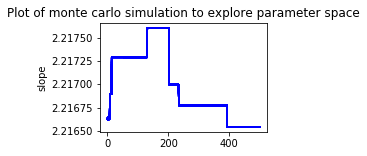

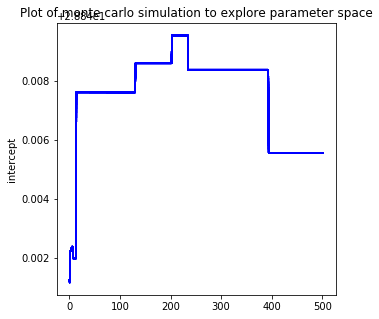

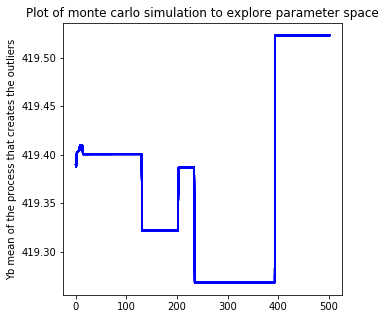

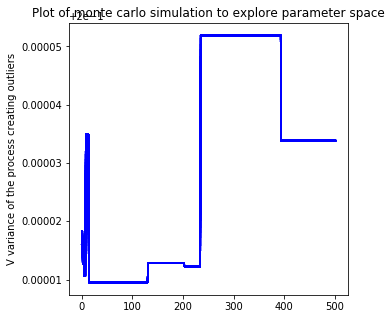

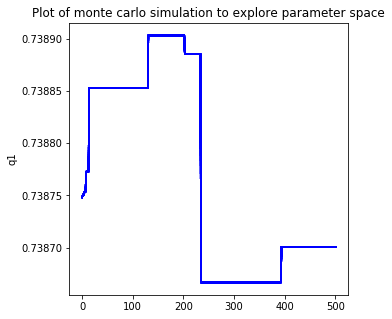

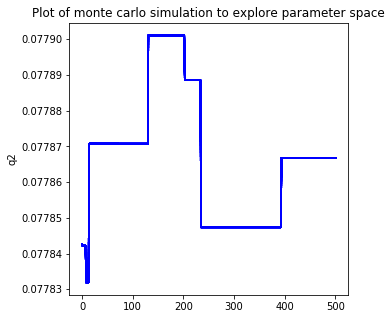

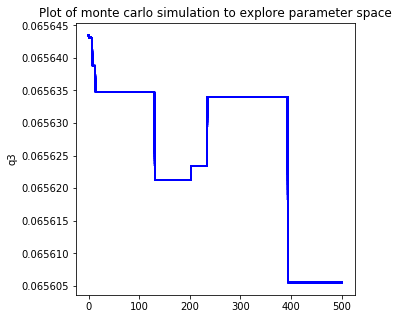

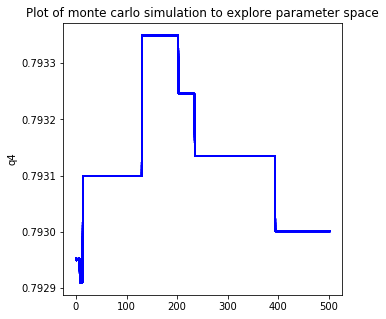

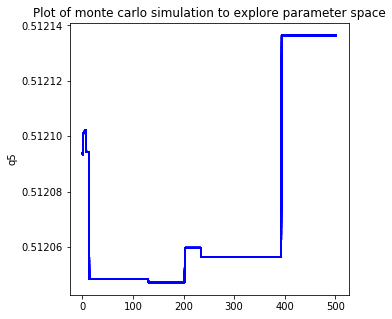

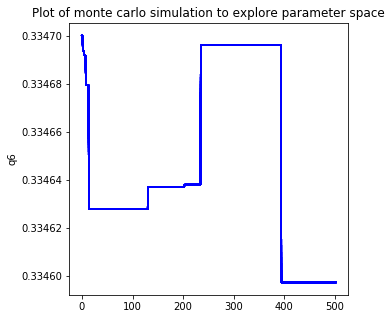

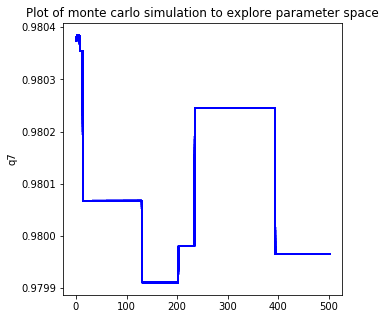

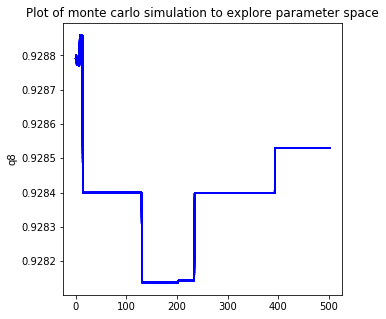

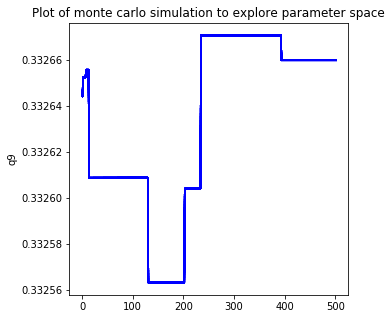

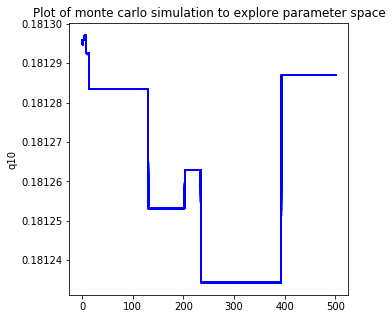

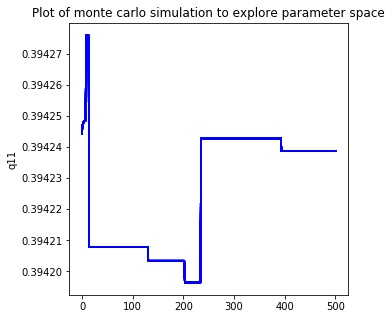

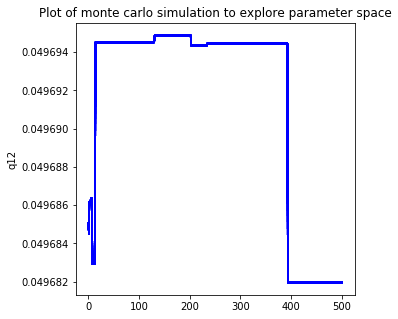

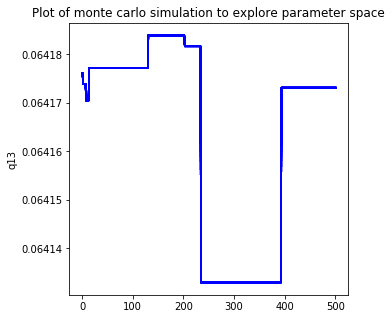

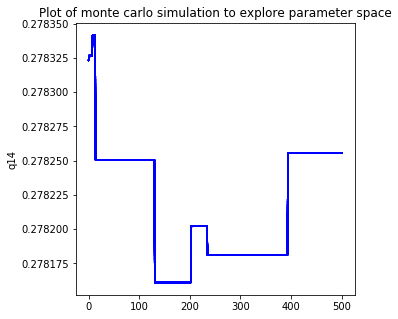

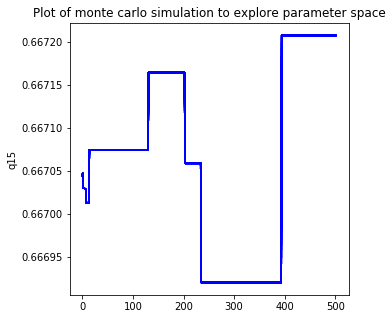

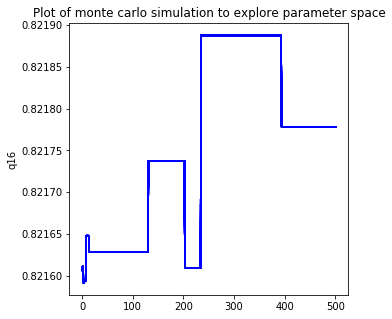

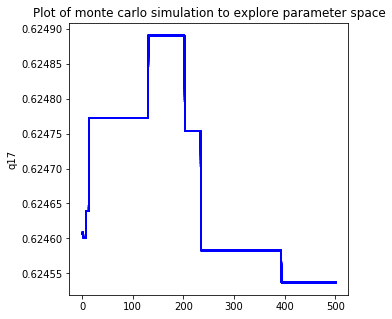

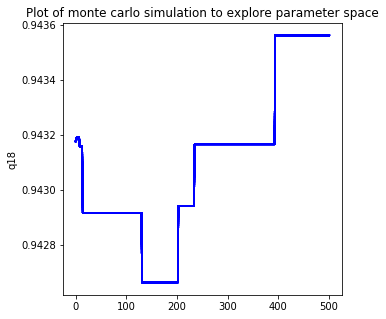

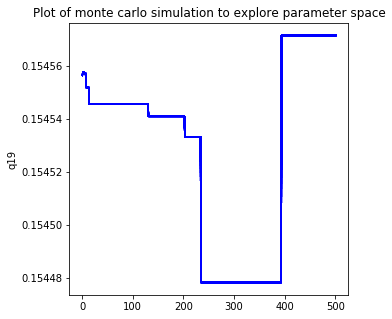

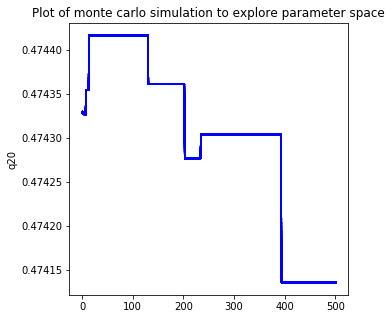

In [47]:
labels = ["slope", "intercept","Yb mean of the process that creates the outliers",
                 "V variance of the process creating outliers", 'q1', 'q2', 'q3',
           'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14',
           'q15', 'q16', 'q17', 'q18', 'q19', 'q20' ]
print(sampler.chain.shape)
for i in range(ndim):
  pl.figure()

  pl.title('Plot of monte carlo simulation to explore parameter space')

  for j in range(100): 
     pl.plot(sampler.chain[1,:,i], 'b', alpha=0.3)
     pl.rcParams["figure.figsize"] = (5,5)

  pl.ylabel(labels[i])
        
pl.title('Plot of monte carlo simulation to explore parameter space')        
        
#burnout = 150
#samples = sampler.chain[:, burnout:, :].reshape((-1, ndim))

In [0]:
        
        
burnout = 150
samples = sampler.chain[:, burnout:, :].reshape((-1, ndim))

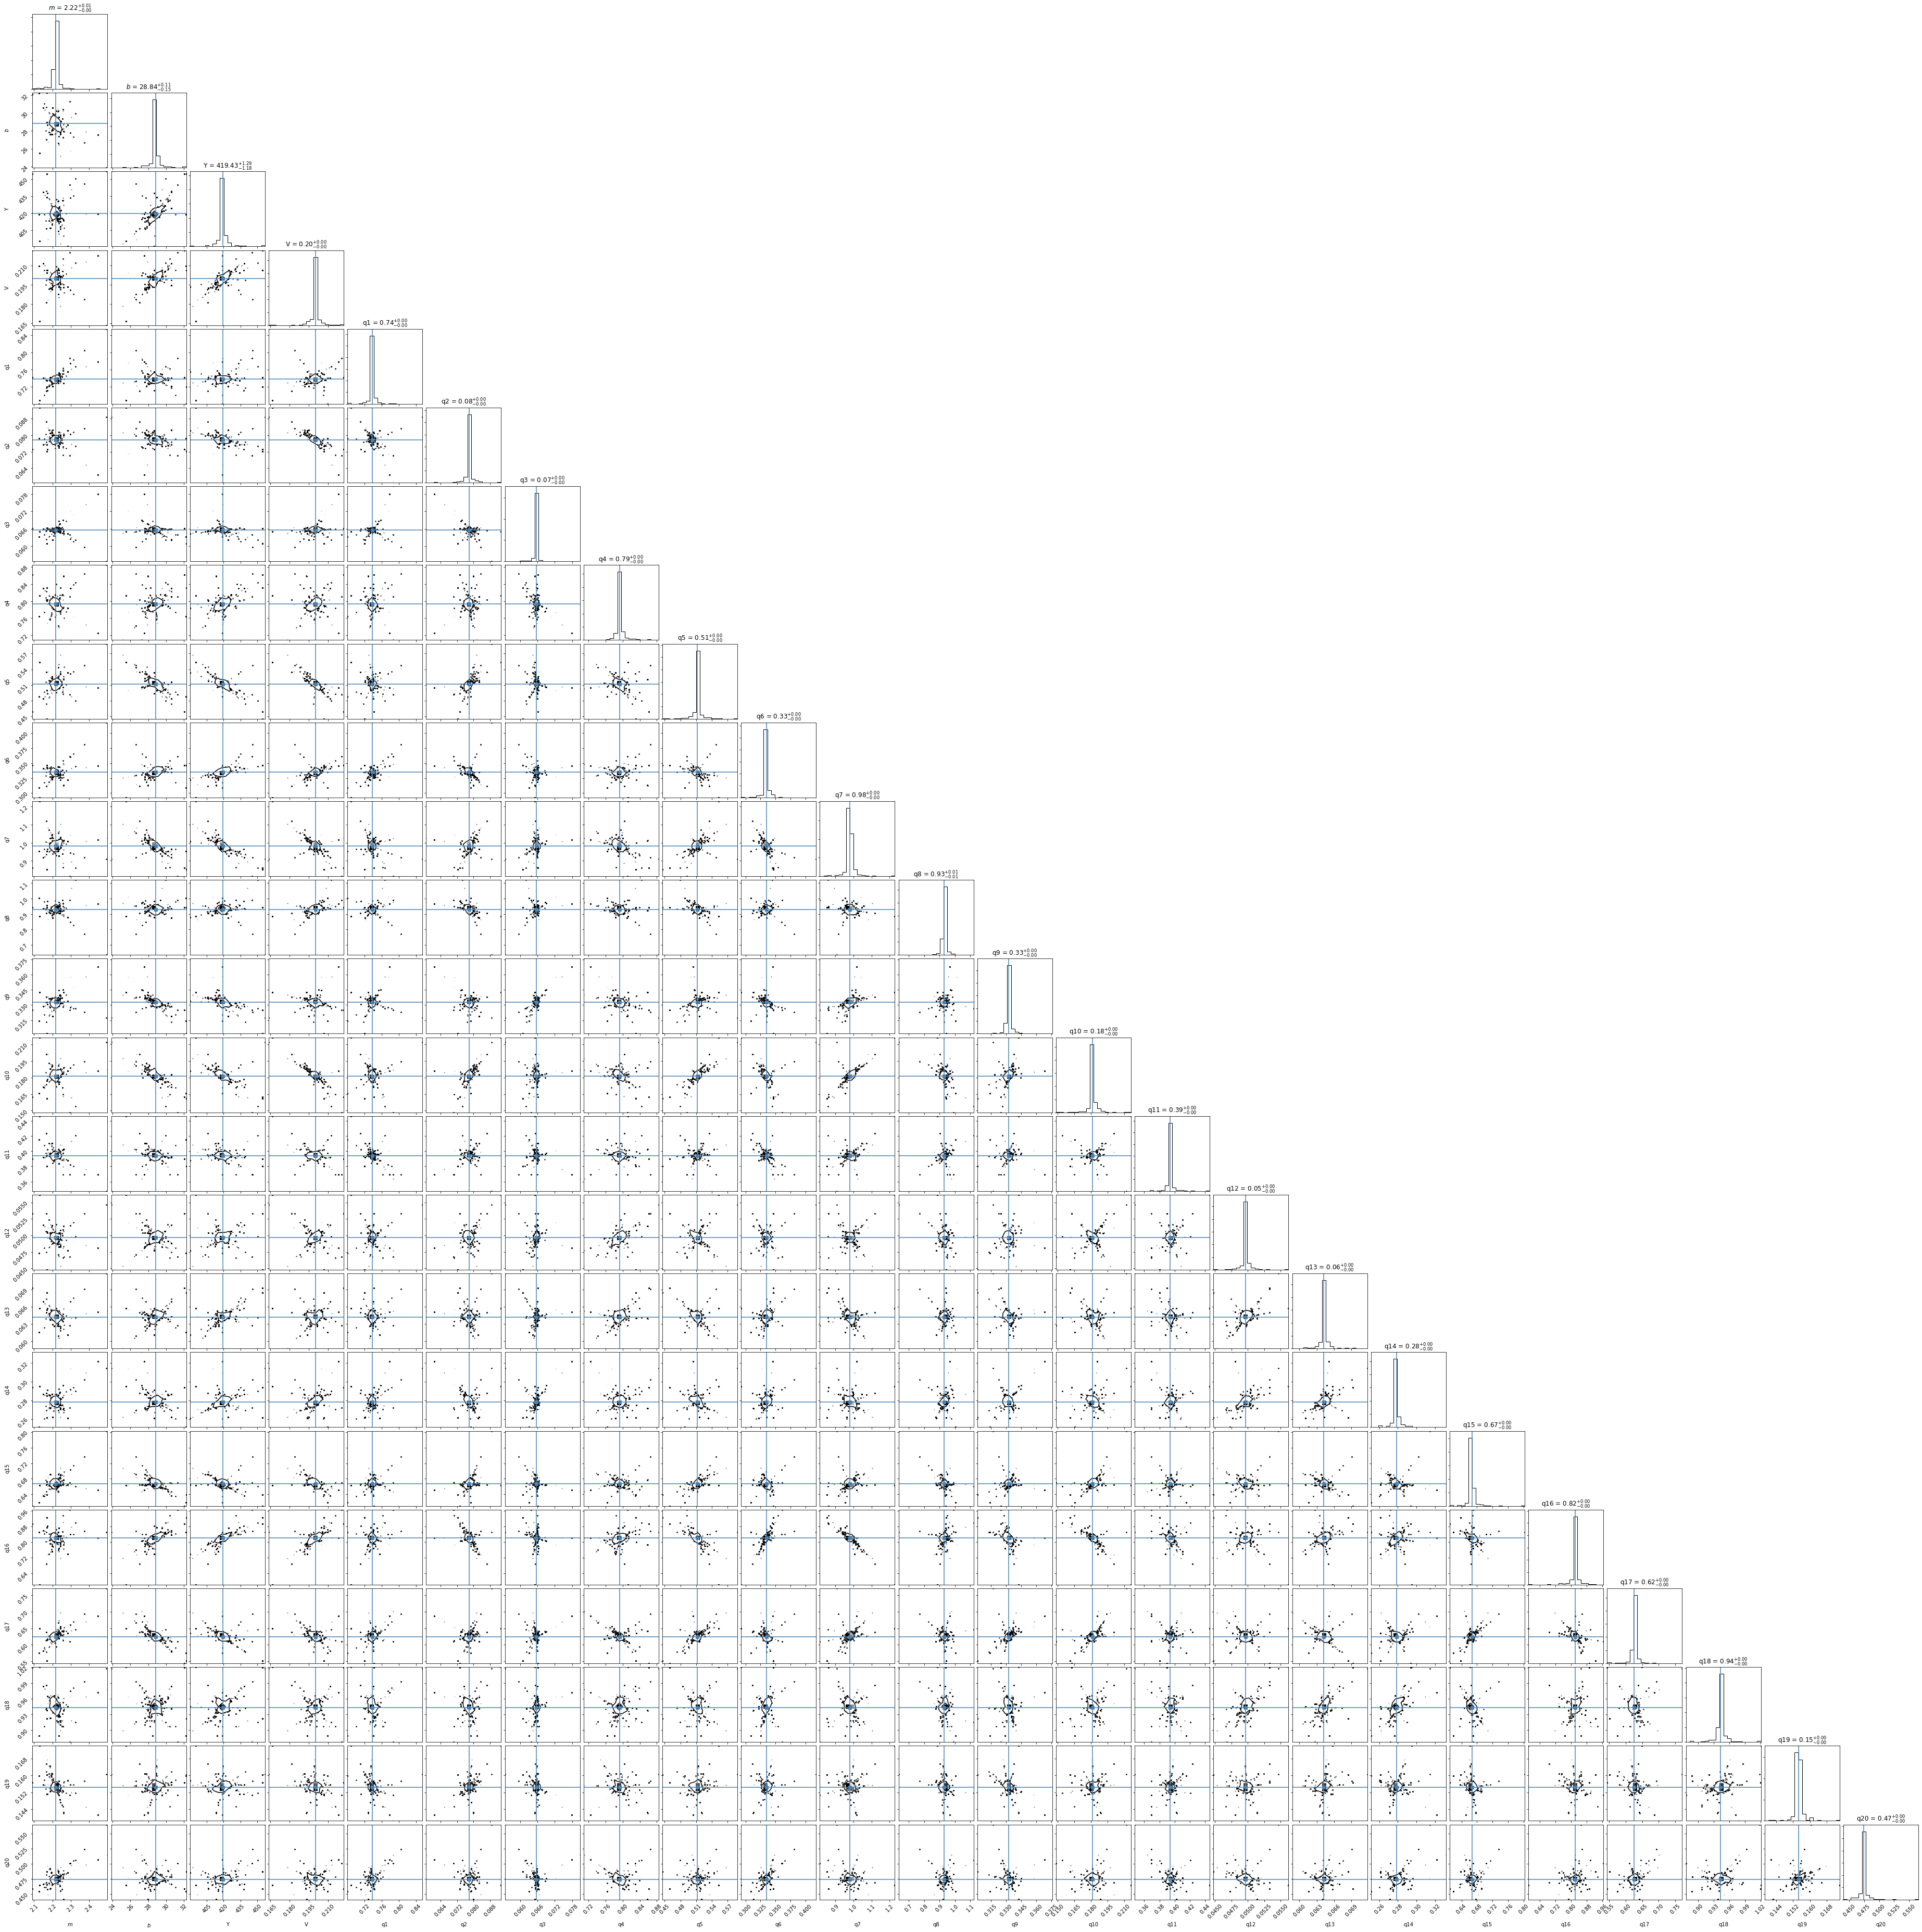

In [49]:
fig = corner.corner(samples, 
                        labels=["$m$", "$b$", "Y", "V",  'q1', 'q2', 'q3',
           'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14',
           'q15', 'q16', 'q17', 'q18', 'q19', 'q20'], show_titles = True,
           figsize=(10,10), truths=probsinit)
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples[:,:2], [16, 50, 84],
                                                axis=0)))
# corner.corner??
fig.title=('Exploring parameter space (m, b) using Monte Carlo')


Fig 10 : The above figure shows exploration of parameter space with monte carlo steps performed using $emcee$. Note the outlier parameters $P_b$, $Y$, $V$ and $q_i$ for $i = 1, 2, ...20$ are added to this model and are explored using $emcee$ here along with original line fitted model parameters m,b. The above figure (histogram) tells that the relevant parameter space has been explored.  

Which parameters del are covariant? Do the parameters span the likelihood effectively? Any suspicious distribution shapes? ????



Which parameters del are covariant?

Ans : The parameters that are correlated or anti-correlated are covariant. In this case, from above figure we see that $Y$ and $m$ are anti-correlated and therefore covariant. Similarly, ($V$ and $m$) are covariant, ($q2$ and $V$) , ($q3$ and $q1$), ($q14$, $m$) etc. 



I got the following error in above plot : 
WARNING:root:Too few points to create valid contours

I believe it occured due to too many features which exacerbated the exploration of parametric space of all 24 features. 

In [50]:
samples.shape

(35200, 24)

In [53]:
# Slope and intercept from MCMC
print("Slope and intercept from MCMC : ", m_mcmc[0], b_mcmc[0])

Slope and intercept from MCMC :  2.216491814905631 28.843129179260973


In [190]:
samples[:,4:].shape
#samples.shape



(35600, 20)

In [57]:
print(samples[-1,4:].shape)
print(samples[-1,:])

(20,)
[2.21748306e+00 2.88416080e+01 4.19239387e+02 2.00273862e-01
 7.40530076e-01 7.77706092e-02 6.56179722e-02 7.93346325e-01
 5.12479161e-01 3.34723164e-01 9.82796469e-01 9.27406212e-01
 3.32935038e-01 1.81286722e-01 3.94120051e-01 4.97026963e-02
 6.41493893e-02 2.78318801e-01 6.67478220e-01 8.21320183e-01
 6.24535544e-01 9.42092722e-01 1.54432939e-01 4.74345582e-01]


**Plot the data points, the best fit line and the lines generated by the MCMC ensambles (as I did in the previous figure) and print a label next to each point that shows the point index (the index of the row corresponding to that point in the source dataframe) and the probability that it is from the Gaussian generative process. Write in red the label if the probability of being an outlier is > 50%**

In [98]:
tol2 = 0.5 
data_line = np.zeros(len(x))
data_outlx = np.zeros(len(x))
data_outly = np.zeros(len(x))
data_outl_p = np.zeros(len(x))
data_ind = np.zeros(len(x))

# print(data_noise.shape)

for ii in range(len(x)):
  #print(samples[-1,4+ii])
  if samples[-1,4+ii] > tol2:
    print(ii, x[ii])
    data_outlx[ii] = x[ii]
    data_outly[ii] = y[ii]
    data_outl_p[ii] = round(samples[-1,4+ii], 2)
    data_ind[ii] = ii



print(data_outly)

0 201
3 287
4 203
6 210
7 202
14 166
15 160
16 186
17 125
[592.   0.   0. 402. 495.   0. 479. 504.   0.   0.   0.   0.   0.   0.
 400. 337. 423. 334.   0.   0.]


Text(0.5, 1.0, 'Different fitting models over the dataset : The model optimized over 24 variables ')

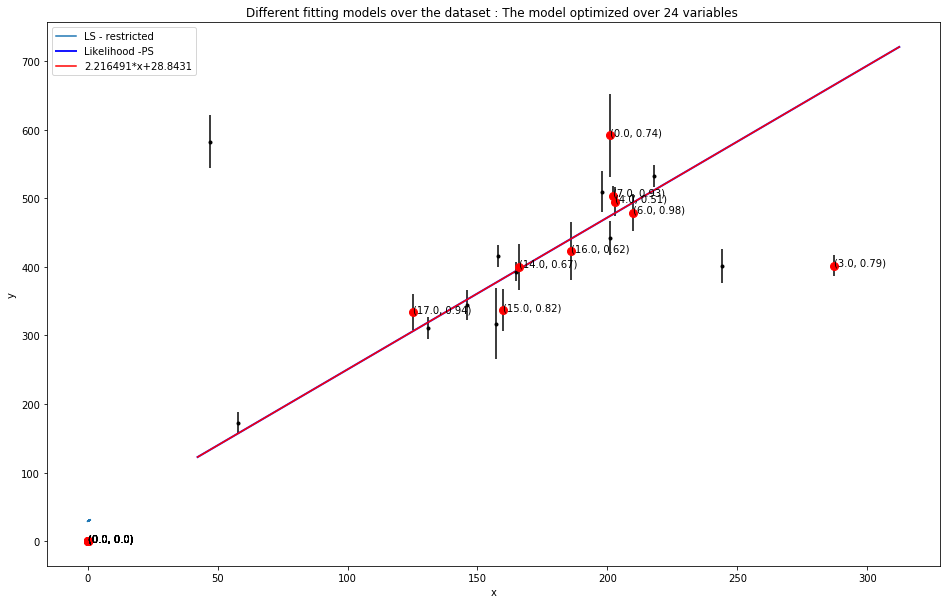

In [99]:
xl = np.arange(data.x.min() * 0.9, data.x.max() * 1.1, 10)
pl.errorbar(data.x, data.y, yerr=data.sy, fmt=".k")
pl.errorbar(data_outlx, data_outly, fmt=".r", ms=16)

for i_x, i_y , i_p , ind in zip(data_outlx, data_outly, data_outl_p, data_ind):
    pl.text(i_x, i_y, '({}, {})'.format(ind, i_p))

pl.plot(xx, line(xx, pars[0], pars[1]), '-', label="LS - restricted")
pl.plot(xl, line(xl, m_mcmc[0], b_mcmc[0]), color="b", lw=2, 
        alpha=0.9, label="Likelihood -PS")

pl.plot(xl, 2.216491814*xl+28.8431, color="r", label="2.216491*x+28.8431")
pl.legend();
pl.xlabel("x")
pl.ylabel("y")
pl.legend();

pl.rcParams["figure.figsize"] = (16,10)
pl.title('Different fitting models over the dataset : The model optimized over 24 variables ')

Fig 10 : The figure above shows comparison of different fitted models. In this case, we used a model with parameters from linelke model i.e. slope and intercept and mean and variance of outlier gaussian distribution and added $20$ features on top to account for the uninformative nature of whether the datapoint under consideration comes from line or outlier. 
The points with probability of $50%$ coming from outlier are shown in red.